# Compendium Exploratory Data Analysis

The human compendium from refine.bio will be much easier to use than loading data from individual manually downloaded data directories. That being said, we'll look at the distribution of genes' expression to make sure there aren't any unexpected differences between groups of samples.

In [1]:
import json
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from plotnine import *
import umap

# __file__ isn't defined for jupyter notebooks
curr_path = os.path.dirname(os.path.abspath(os.path.abspath('')))
whistl_path = os.path.join(curr_path, os.pardir, 'whistl')
sys.path.append(whistl_path)
import utils

In [2]:
map_file = os.path.join(curr_path, os.pardir, 'data', 'sample_classifications.pkl')
sample_to_label = utils.parse_map_file(map_file)
sample_ids = sample_to_label.keys()

In [3]:
# Not all labeled samples show up in the compendium, which causes pandas to panic. To fix this we have to 
# take the intersection of the accessions in sample_ids and the accessions in the compendium
compendium_path = os.path.join(curr_path, os.pardir, 'data', 'human_compendium', 'HOMO_SAPIENS.tsv')

header_ids = None
with open(compendium_path) as in_file:
    header = in_file.readline()
    header_ids = header.split('\t')
print(len(header_ids))

valid_sample_ids = [id_ for id_ in sample_ids if id_ in header_ids]
print(len(sample_ids))
print(len(valid_sample_ids))

# This is hacky, but the devs explicitly want to index_col to pull from only cols in usecols so there isn't
# a better way to do it without manually changing the original file
# Further reading https://github.com/pandas-dev/pandas/issues/9098 and 
# https://github.com/pandas-dev/pandas/issues/2654
valid_sample_ids.append('Unnamed: 0')

430120
8166
7673


In [4]:
%%time
compendium_df = pd.read_csv(compendium_path, sep='\t', index_col=0, usecols=valid_sample_ids)

CPU times: user 43min 6s, sys: 54.9 s, total: 44min 1s
Wall time: 46min 22s


In [5]:
compendium_df.head()

,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58HA300104,E-MEXP-1635-04SE59HA300104,E-MEXP-1635-04SE60HA300104,E-MEXP-1635-04SE61HA300104,E-MEXP-1635-04SE62HA300104,E-MEXP-1635-04SE63HA300104,E-MEXP-1635-04SE649HGU133A_201004,E-MEXP-1635-04SE64HA300104,E-MEXP-1635-04SE650HGU133A_201004,...,SRR6870393,SRR6870394,SRR6870395,SRR6870396,SRR6870397,SRR6870398,SRR6870399,SRR6870400,SRR6870401,SRR6870402
ENSG00000000003,0.208914,0.247681,0.133060,0.225220,0.225110,0.145763,0.203744,0.101624,0.216774,0.137222,...,0.244141,0.287628,0.234996,0.179500,0.262060,0.264090,0.248505,0.248617,0.231635,0.220124
ENSG00000000005,-0.060592,-0.057062,-0.015866,-0.076875,-0.011201,-0.055769,-0.060138,-0.000146,-0.039444,0.068918,...,-0.171151,-0.170181,-0.168437,-0.165942,-0.167972,-0.166330,-0.160954,-0.161027,-0.164263,-0.164568
ENSG00000000419,6.833205,9.714408,9.193253,10.588144,10.091911,9.000752,7.399193,7.174791,8.533220,9.249745,...,0.703249,0.713038,0.970236,1.070772,0.961582,1.051032,1.369086,1.264025,0.869870,0.743825
ENSG00000000457,0.214447,0.087237,0.402771,0.209681,0.141353,0.253218,0.188318,0.908775,0.174844,0.388580,...,2.497381,2.674494,2.394772,2.429598,2.450469,2.638023,2.240824,2.407291,1.933599,2.470088
ENSG00000000460,-0.057339,-0.034758,-0.043255,-0.078963,-0.096355,-0.098674,0.005090,0.037494,-0.033465,-0.112916,...,0.693359,0.464540,0.580630,0.692895,0.408506,0.515283,0.653895,0.437554,0.306867,0.569878


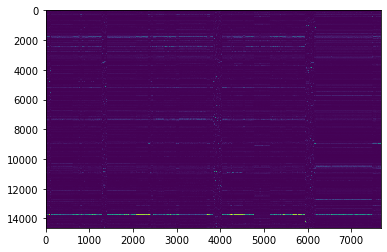

In [6]:
plt.imshow(compendium_df.values, aspect='auto')

### Plot analysis
There appears to be some samples that have severely different expression from the others. It's hard to see here though. I'll plot the expression distribution then threshold it to keep the lowly expressed genes from getting washed out by the highly expressed few

In [7]:
compendium_df = compendium_df.reset_index().rename(columns={'index': 'Gene'})
compendium_df.head()

,Gene,E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58HA300104,E-MEXP-1635-04SE59HA300104,E-MEXP-1635-04SE60HA300104,E-MEXP-1635-04SE61HA300104,E-MEXP-1635-04SE62HA300104,E-MEXP-1635-04SE63HA300104,E-MEXP-1635-04SE649HGU133A_201004,E-MEXP-1635-04SE64HA300104,...,SRR6870393,SRR6870394,SRR6870395,SRR6870396,SRR6870397,SRR6870398,SRR6870399,SRR6870400,SRR6870401,SRR6870402
0,ENSG00000000003,0.208914,0.247681,0.133060,0.225220,0.225110,0.145763,0.203744,0.101624,0.216774,...,0.244141,0.287628,0.234996,0.179500,0.262060,0.264090,0.248505,0.248617,0.231635,0.220124
1,ENSG00000000005,-0.060592,-0.057062,-0.015866,-0.076875,-0.011201,-0.055769,-0.060138,-0.000146,-0.039444,...,-0.171151,-0.170181,-0.168437,-0.165942,-0.167972,-0.166330,-0.160954,-0.161027,-0.164263,-0.164568
2,ENSG00000000419,6.833205,9.714408,9.193253,10.588144,10.091911,9.000752,7.399193,7.174791,8.533220,...,0.703249,0.713038,0.970236,1.070772,0.961582,1.051032,1.369086,1.264025,0.869870,0.743825
3,ENSG00000000457,0.214447,0.087237,0.402771,0.209681,0.141353,0.253218,0.188318,0.908775,0.174844,...,2.497381,2.674494,2.394772,2.429598,2.450469,2.638023,2.240824,2.407291,1.933599,2.470088
4,ENSG00000000460,-0.057339,-0.034758,-0.043255,-0.078963,-0.096355,-0.098674,0.005090,0.037494,-0.033465,...,0.693359,0.464540,0.580630,0.692895,0.408506,0.515283,0.653895,0.437554,0.306867,0.569878


In [8]:
melted_df = pd.melt(compendium_df, id_vars=['Gene'], var_name=['Study',], value_name='Expression')

In [9]:
melted_df.head()

,Gene,Study,Expression
0,ENSG00000000003,E-MEXP-1635-04SE57HA300104,0.208914
1,ENSG00000000005,E-MEXP-1635-04SE57HA300104,-0.060592
2,ENSG00000000419,E-MEXP-1635-04SE57HA300104,6.833205
3,ENSG00000000457,E-MEXP-1635-04SE57HA300104,0.214447
4,ENSG00000000460,E-MEXP-1635-04SE57HA300104,-0.057339


/home/ben/anaconda3/envs/whistl/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 22106'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


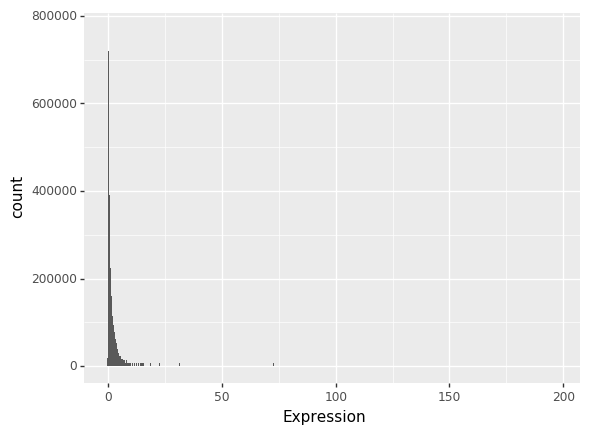

<ggplot: (8772071721405)>

In [10]:
ggplot(melted_df, aes(x='Expression')) + geom_histogram()

In [11]:
vis_df = compendium_df.copy()
vis_df = vis_df.set_index('Gene')
vis_df[vis_df > 5] = 0

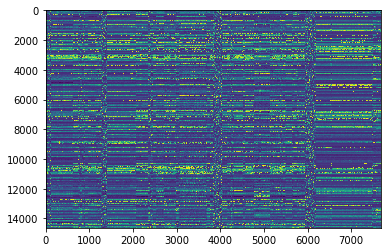

In [12]:
plt.imshow(vis_df.values, aspect='auto')

### Plot analysis
The pattern of distorted expression is much stronger here. I would guess that they correspond to studies using a different platform, but it's also possible that they correspond to very young or old patients or something.

If I were a pyplot wizard, I could probably plot which samples correspond to which studies. Because I am not, I'll  pull out column ranges and see if anything is obvious

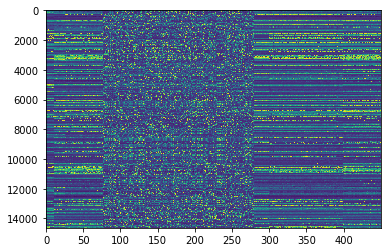

In [13]:
plt.imshow(vis_df.iloc[:, 3750:4200], aspect='auto')

### Plot analysis
I kind of expected the band to be complete noise, but there does seem to be correlation at least within genes for the gene expression. This may be due to the preprocessing of the compendium though.

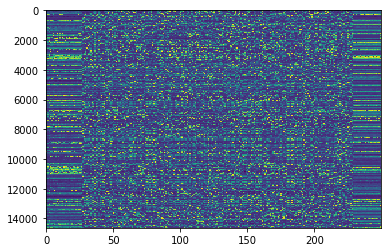

In [14]:
plt.imshow(vis_df.iloc[:, 3800:4050], aspect='auto')

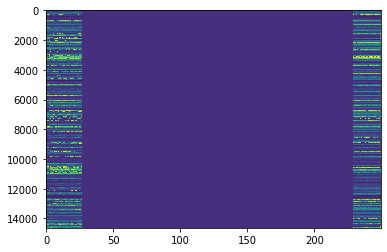

In [15]:
mask_df = vis_df.copy()

bad_study_accessions = ['GSM2203540', 'GSM2203541', 'GSM2203542', 'GSM2203543', 'GSM2203544', 'GSM2203545', 'GSM2203546', 'GSM2203547', 'GSM2203548', 'GSM2203549', 'GSM2203550', 'GSM2203551', 'GSM2203552', 'GSM2203553', 'GSM2203554', 'GSM2203555', 'GSM2203556', 'GSM2203557', 'GSM2203558', 'GSM2203559', 'GSM2203560', 'GSM2203561', 'GSM2203562', 'GSM2203563', 'GSM2203564', 'GSM2203565', 'GSM2203566', 'GSM2203567', 'GSM2203568', 'GSM2203569', 'GSM2203570', 'GSM2203571', 'GSM2203572', 'GSM2203573', 'GSM2203574', 'GSM2203575', 'GSM2203576', 'GSM2203577', 'GSM2203578', 'GSM2203579', 'GSM2203580', 'GSM2203581', 'GSM2203582', 'GSM2203583', 'GSM2203584', 'GSM2203585', 'GSM2203586', 'GSM2203587', 'GSM2203588', 'GSM2203589', 'GSM2203590', 'GSM2203591', 'GSM2203592', 'GSM2203593', 'GSM2203594', 'GSM2203595', 'GSM2203596', 'GSM2203597', 'GSM2203598', 'GSM2203599', 'GSM2203600', 'GSM2203601', 'GSM2203602', 'GSM2203603', 'GSM2203604', 'GSM2203605', 'GSM2203606', 'GSM2203607', 'GSM2203608', 'GSM2203609', 'GSM2203610', 'GSM2203611', 'GSM2203612', 'GSM2203613', 'GSM2203614', 'GSM2203615', 'GSM2203616', 'GSM2203617', 'GSM2203618', 'GSM2203619', 'GSM2203620', 'GSM2203621', 'GSM2203622', 'GSM2203623', 'GSM2203624', 'GSM2203625', 'GSM2203626', 'GSM2203627', 'GSM2203628', 'GSM2203629', 'GSM2203630', 'GSM2203631', 'GSM2203632', 'GSM2203633', 'GSM2203634', 'GSM2203635', 'GSM2203636', 'GSM2203637', 'GSM2203638', 'GSM2203639', 'GSM2203640', 'GSM2203641', 'GSM2203642', 'GSM2203643', 'GSM2203644', 'GSM2203645', 'GSM2203646', 'GSM2203647', 'GSM2203648', 'GSM2203649', 'GSM2203650', 'GSM2203651', 'GSM2203652', 'GSM2203653', 'GSM2203654', 'GSM2203655', 'GSM2203656', 'GSM2203657', 'GSM2203658', 'GSM2203659', 'GSM2203660', 'GSM2203661', 'GSM2203662', 'GSM2203663', 'GSM2203664', 'GSM2203665', 'GSM2203666', 'GSM2203667', 'GSM2203668', 'GSM2203669', 'GSM2203670', 'GSM2203671', 'GSM2203672', 'GSM2203673', 'GSM2203674', 'GSM2203675', 'GSM2203676', 'GSM2203677', 'GSM2203678', 'GSM2203679', 'GSM2203680', 'GSM2203681', 'GSM2203682', 'GSM2203683', 'GSM2203684', 'GSM2203685', 'GSM2203686', 'GSM2203687', 'GSM2203688', 'GSM2203689', 'GSM2203690', 'GSM2203691', 'GSM2203692', 'GSM2203693', 'GSM2203694', 'GSM2203695', 'GSM2203696', 'GSM2203697', 'GSM2203698', 'GSM2203699', 'GSM2203700', 'GSM2203701', 'GSM2203702', 'GSM2203703', 'GSM2203704', 'GSM2203705', 'GSM2203706', 'GSM2203707', 'GSM2203708', 'GSM2203709', 'GSM2203710', 'GSM2203711', 'GSM2203712', 'GSM2203713', 'GSM2203714', 'GSM2203715', 'GSM2203716', 'GSM2203717', 'GSM2203718', 'GSM2203719', 'GSM2203720', 'GSM2203721', 'GSM2203722', 'GSM2203723', 'GSM2203724', 'GSM2203725', 'GSM2203726', 'GSM2203727', 'GSM2203728', 'GSM2203729', 'GSM2203730', 'GSM2203731', 'GSM2203732', 'GSM2203733', 'GSM2203734', 'GSM2203735', 'GSM2203736', 'GSM2203737', 'GSM2203738', 'GSM2203739', 'GSM2203740', 'GSM2203741']

mask_df.loc[:, bad_study_accessions] = 0
plt.imshow(mask_df.iloc[:, 3800:4050], aspect='auto')

In [16]:
print(list(vis_df.iloc[:, 3800:4050].columns))

['GSM201277', 'GSM201278', 'GSM201279', 'GSM201280', 'GSM201281', 'GSM201282', 'GSM201283', 'GSM201284', 'GSM201285', 'GSM201286', 'GSM201287', 'GSM201288', 'GSM201289', 'GSM201290', 'GSM201291', 'GSM201292', 'GSM201293', 'GSM201294', 'GSM201295', 'GSM201296', 'GSM201297', 'GSM201298', 'GSM201300', 'GSM201301', 'GSM201302', 'GSM201303', 'GSM201304', 'GSM2203540', 'GSM2203541', 'GSM2203542', 'GSM2203543', 'GSM2203544', 'GSM2203545', 'GSM2203546', 'GSM2203547', 'GSM2203548', 'GSM2203549', 'GSM2203550', 'GSM2203551', 'GSM2203552', 'GSM2203553', 'GSM2203554', 'GSM2203555', 'GSM2203556', 'GSM2203557', 'GSM2203558', 'GSM2203559', 'GSM2203560', 'GSM2203561', 'GSM2203562', 'GSM2203563', 'GSM2203564', 'GSM2203565', 'GSM2203566', 'GSM2203567', 'GSM2203568', 'GSM2203569', 'GSM2203570', 'GSM2203571', 'GSM2203572', 'GSM2203573', 'GSM2203574', 'GSM2203575', 'GSM2203576', 'GSM2203577', 'GSM2203578', 'GSM2203579', 'GSM2203580', 'GSM2203581', 'GSM2203582', 'GSM2203583', 'GSM2203584', 'GSM2203585', 'GSM

#### Looking just at the accession strings, it looks like there's a huge block of samples belonging to the same study that are roughly where the noise is (GSM2203540 - GSM2203741). Digging further, all the samples belong to study GSE83456, a tuberculosis study with a range of patient ages and case/control status.

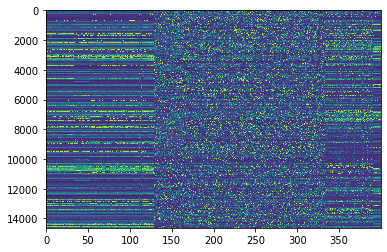

In [17]:
plt.imshow(vis_df.iloc[:, 5800:6200], aspect='auto')

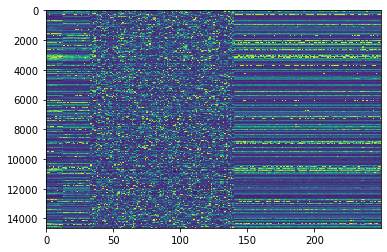

In [18]:
plt.imshow(vis_df.iloc[:, 1250:1500], aspect='auto')

In [19]:
print(list(vis_df.iloc[:, 1300:1375].columns))

['GSM1410465', 'GSM1410466', 'GSM1410467', 'GSM1410468', 'GSM1410469', 'GSM1410470', 'GSM1410471', 'GSM1410472', 'GSM1410473', 'GSM1410474', 'GSM1410475', 'GSM1410476', 'GSM1410477', 'GSM1410478', 'GSM1410479', 'GSM1410480', 'GSM1410481', 'GSM1410482', 'GSM1410483', 'GSM1410484', 'GSM1410485', 'GSM1410486', 'GSM1410487', 'GSM1410488', 'GSM1410489', 'GSM1410490', 'GSM1410491', 'GSM1410492', 'GSM1410493', 'GSM1410494', 'GSM1410495', 'GSM1410496', 'GSM1410497', 'GSM1410498', 'GSM1410499', 'GSM1410500', 'GSM1410501', 'GSM1410502', 'GSM1410503', 'GSM1410504', 'GSM1410505', 'GSM1410506', 'GSM1410507', 'GSM1410508', 'GSM1410509', 'GSM1410510', 'GSM1410511', 'GSM1410512', 'GSM1410513', 'GSM1410514', 'GSM1410515', 'GSM1410516', 'GSM1410517', 'GSM1410518', 'GSM1410519', 'GSM1410520', 'GSM1410521', 'GSM1410522', 'GSM1410523', 'GSM1410524', 'GSM1410525', 'GSM1410526', 'GSM1410527', 'GSM1410528', 'GSM1410529', 'GSM1410530', 'GSM1410531', 'GSM1410532', 'GSM1410533', 'GSM1410534', 'GSM1410535', 'GSM1

### Results
It appears that the source of the noisy pixels is the samples that come from beadchips. I'll want to remove those from my analysis. Unfortunately those are a large portion of my tuberculosis samples :(

In [20]:
metadata_file = os.path.join(curr_path, os.pardir, 'data', 'all_metadata.json')
metadata_json = json.load(open(metadata_file))

In [21]:
sample_metadata = metadata_json['samples']
good_samples = []

for sample in sample_metadata:
    if 'beadchip' not in sample_metadata[sample]['refinebio_platform'].lower():
        good_samples.append(sample)

In [22]:
non_bead_df = vis_df.loc[:, good_samples]
non_bead_df = non_bead_df.dropna(axis='columns')

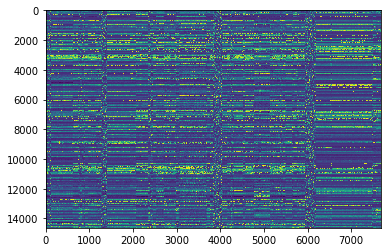

In [23]:
plt.imshow(vis_df, aspect='auto')

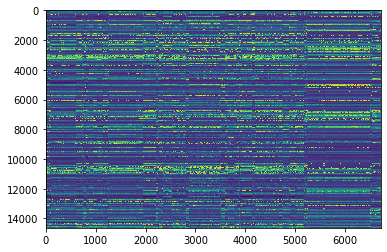

In [24]:
plt.imshow(non_bead_df.values, aspect='auto')

### Plot Analysis
Pulling out beadchip arrays seems to have gotten rid of most of the noise, though you can see a pretty clear difference between RNAseq samples (at the end) and microarray samples

## Data Subgroup Visualization
The rest of this notebook plots various features of the data such as platform, disease, and study to see which features contribute the most variation in UMAP space

In [25]:
rna_cols = [col for col in non_bead_df.columns if 'SRR' in col]
microarray_cols = [col for col in non_bead_df.columns if 'SRR' not in col]

print(rna_cols[:3])
print(microarray_cols[:3])
print(len(rna_cols))
print(len(microarray_cols))

['SRR1652895', 'SRR1652897', 'SRR1652898']
['E-MEXP-1635-04SE57HA300104', 'E-MEXP-1635-04SE58HA300104', 'E-MEXP-1635-04SE59HA300104']
1540
5171


In [26]:
umap_df = compendium_df.copy()
umap_df = umap_df.set_index('Gene')
umap_df = umap_df.loc[:, good_samples]
umap_df = umap_df.dropna(axis='columns')
umap_df = umap_df.transpose()
umap_df.head()

Gene,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000278845,ENSG00000278921,ENSG00000279324,ENSG00000279364,ENSG00000279636,ENSG00000280109,ENSG00000280237,ENSG00000282988,ENSG00000283597,ENSG00000283632
E-MEXP-1635-04SE57HA300104,0.208914,-0.060592,6.833205,0.214447,-0.057339,14.716667,0.333249,1.973349,2.481825,1.198605,...,3.556903,-0.150116,0.075878,-0.197360,0.250837,1.343591,0.893074,-0.148781,-0.134957,1.630485
E-MEXP-1635-04SE58HA300104,0.247681,-0.057062,9.714408,0.087237,-0.034758,15.627227,0.560429,1.990947,2.728084,1.006605,...,3.503867,-0.140382,0.015777,-0.158905,0.222942,1.278304,0.866655,-0.141766,-0.160663,1.456953
E-MEXP-1635-04SE59HA300104,0.133060,-0.015866,9.193253,0.402771,-0.043255,10.489084,0.407717,1.853691,2.586305,0.707855,...,3.535144,-0.160516,0.111114,-0.194840,0.102308,0.877241,0.893358,-0.138150,-0.157599,1.304510
E-MEXP-1635-04SE60HA300104,0.225220,-0.076875,10.588144,0.209681,-0.078963,10.081331,0.665616,2.025645,2.366040,0.990498,...,3.440013,-0.118642,0.089987,-0.164568,0.233276,0.850390,0.701288,-0.054042,-0.153946,1.290186
E-MEXP-1635-04SE61HA300104,0.225110,-0.011201,10.091911,0.141353,-0.096355,10.690051,0.417136,2.019385,2.557729,0.981246,...,3.470510,-0.135320,-0.032727,-0.142403,0.163395,0.908470,0.890081,-0.170989,-0.166252,1.437998


In [27]:
%%capture

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(umap_df.values)

In [28]:
print(embedding.shape)

(6711, 2)


In [29]:
embedding_df = {'Study': umap_df.index, 'umap_1': embedding[:,0], 'umap_2': embedding[:,1]}
embedding_df = pd.DataFrame(embedding_df)
embedding_df['is_rna_seq'] = embedding_df['Study'].str.contains('SRR')
embedding_df.head()

,Study,umap_1,umap_2,is_rna_seq
0,E-MEXP-1635-04SE57HA300104,-1.715968,3.650024,False
1,E-MEXP-1635-04SE58HA300104,-1.828382,3.561168,False
2,E-MEXP-1635-04SE59HA300104,-1.805069,3.557720,False
3,E-MEXP-1635-04SE60HA300104,-1.677892,3.668453,False
4,E-MEXP-1635-04SE61HA300104,-1.680913,3.686800,False


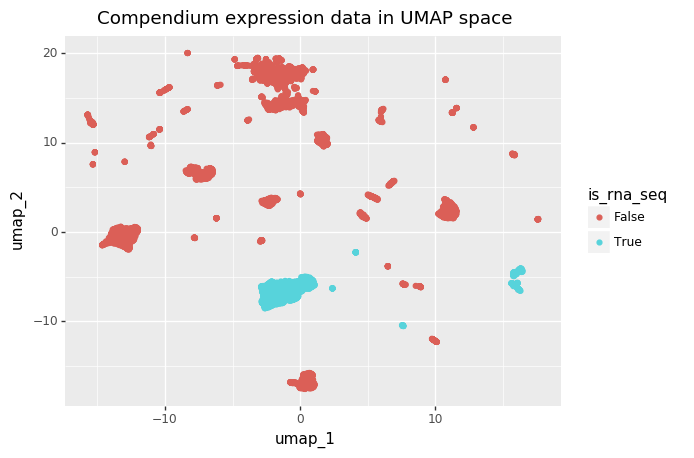

<ggplot: (8771856015301)>

In [30]:
(ggplot(embedding_df, aes(x='umap_1', y='umap_2', color='is_rna_seq')) +
 geom_point() +
 ggtitle('Compendium expression data in UMAP space')
)

### Analysis
Unsurprisingly, RNA-seq and microarray studies fall out in separate clusters. It'll be interesting to see how diseases/studies/platforms are separated

In [31]:
# Studies
sample_to_study = {}

experiments = metadata_json['experiments']

for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

In [32]:
platforms = []
labels = []
studies = []
tissues = []

for sample in embedding_df['Study']:
    platforms.append(sample_metadata[sample]['refinebio_platform'].lower())
    labels.append(sample_to_label[sample])
    studies.append(sample_to_study[sample])
    

embedding_df['platform'] = platforms
embedding_df['label'] = labels
embedding_df['study'] = studies

embedding_df.head()

,Study,umap_1,umap_2,is_rna_seq,platform,label,study
0,E-MEXP-1635-04SE57HA300104,-1.715968,3.650024,False,affymetrix human genome u133a array (hgu133a),healthy,E-MEXP-1635
1,E-MEXP-1635-04SE58HA300104,-1.828382,3.561168,False,affymetrix human genome u133a array (hgu133a),healthy,E-MEXP-1635
2,E-MEXP-1635-04SE59HA300104,-1.805069,3.557720,False,affymetrix human genome u133a array (hgu133a),healthy,E-MEXP-1635
3,E-MEXP-1635-04SE60HA300104,-1.677892,3.668453,False,affymetrix human genome u133a array (hgu133a),healthy,E-MEXP-1635
4,E-MEXP-1635-04SE61HA300104,-1.680913,3.686800,False,affymetrix human genome u133a array (hgu133a),healthy,E-MEXP-1635


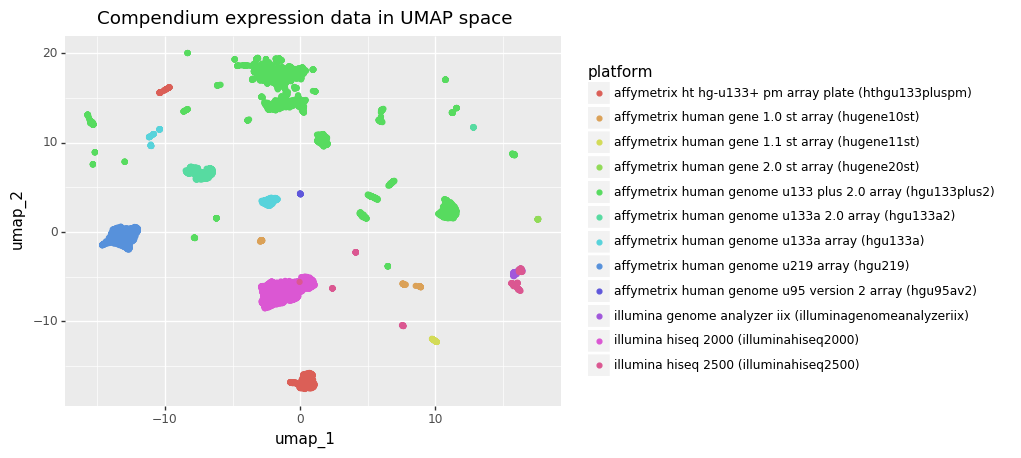

<ggplot: (8771721123885)>

In [33]:
(ggplot(embedding_df, aes(x='umap_1', y='umap_2', color='platform')) +
 geom_point() +
 ggtitle('Compendium expression data in UMAP space')
)

### Analysis
It looks like samples from the same platform like to cluster together, which is unsurprising. Intersetingly the illumina genome analyzer iix that looked noisy earlier clusters closely to to the illumina hiseq 2500 samples

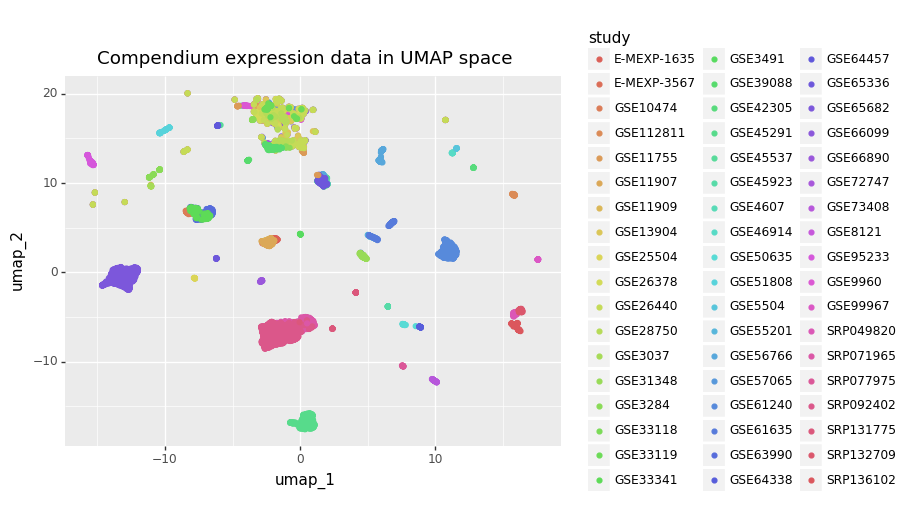

<ggplot: (8772071002045)>

In [34]:
(ggplot(embedding_df, aes(x='umap_1', y='umap_2', color='study')) +
 geom_point() +
 ggtitle('Compendium expression data in UMAP space')
)

### Analysis
The platform seems to have a much larger effect on the clustering of gene expression data than the study does. This is surprising

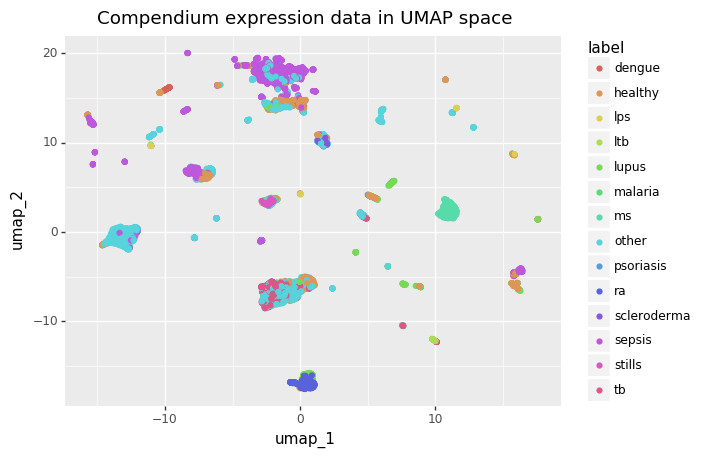

<ggplot: (8771766084477)>

In [35]:
(ggplot(embedding_df, aes(x='umap_1', y='umap_2', color='label')) +
 geom_point() +
 ggtitle('Compendium expression data in UMAP space')
)

### Analysis
Within the clusters created by the platforms, the diseases seem to separate out from the healthy samples pretty well

## Conclusions
There is definitely variation between the different diseases and studies. It will be interesting to see how well we can compensate for it